In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[0.007716178894042969] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital-naive-concat/', load=True, concate=True, mode="ft")

INFO:profiler.utility:[0.15484023094177246] Load Embedding start

INFO:profiler.utility:[0.23013019561767578] Load Embedding execution time: 0.07528996467590332



In [6]:
# load clean data
pf2 = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)
pf2.session.load_data(name='hospital', src=FILE, fpath='data/hospital_clean_unflatten.csv', check_param=True, na_values='empty')
pf2.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.utility:[4.792213439941406e-05] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "numeric",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "numeric",
    "CountyName": "text",
    "PhoneNumber": "numeric",
    "HospitalType": "categorical",
    "HospitalOwner": "categorical",
    "EmergencyService": "categorical",
    "Condition": "categorical",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hos

In [7]:
clean = pf2.session.ds.df['HospitalName']
dirty = pf.session.ds.df['HospitalName']
vec = pf.session.embed.models['HospitalName'].vec
vocab = pf.session.embed.models['HospitalName'].vocab

In [8]:
import pandas as pd

In [9]:
import sklearn
# 1. calculate cosine distances with all other values in the domain 
distance = sklearn.metrics.pairwise.cosine_distances(vec)

In [10]:
dis_with_same = []
dis_with_other = []
vocab['index'] = vocab['index'].astype(int)
for i, cell in enumerate(vocab.index):
    if not isinstance(cell, np.str):
        continue
    # for each word, find the corresponding correct word in clean data
    clean_cell = clean.loc[dirty.index[dirty==cell][0]]
    # find the index of the words in dirty vocab that equals to this word in groudtruth
    variations = dirty[(clean==clean_cell) & (dirty != cell)]
    variations = np.unique(variations[~pd.isnull(variations)])
    if len(variations) == 0:
        continue
    print("cell: %s"%cell)
    similar_idx = vocab.loc[variations,'index'].values
    same_idx = [vocab.loc[cell, 'index']]
    dis_with_same.extend(distance[i, similar_idx])
    print("\n-- distance with variational representations of the word -- ")
    maxdis = -1
    for word, dis in zip(variations, distance[i, vocab.loc[variations, 'index']]):
        print("%s (%.4f)"%(word, dis))
        maxdis = max(dis, maxdis)
    
    nonsimilar_idx = np.array(list(set(vocab['index'].values) - set(similar_idx) - set(same_idx)))

    nonsimilar_dis = distance[i, nonsimilar_idx]
    dis_with_other.extend(nonsimilar_dis)
    print("\n-- nonsimilar words but with small distances --")
    for word, dis in zip(vocab.index.values[nonsimilar_idx[nonsimilar_dis<maxdis]], nonsimilar_dis[nonsimilar_dis<maxdis]):
        print("%s (%.4f)"%(word, dis))
    print("\n====")

cell: alaska regional hospital

-- distance with variational representations of the word -- 
xlxskx regionxl hospitxl (0.2472)

-- nonsimilar words but with small distances --
andalusia regional hospital (0.0600)
andaluxia regional hoxpital (0.1867)
andaxusia regionax hospitax (0.1486)
cherokee medical center (0.2324)
chilton medical center (0.2333)
crenshaw community hospital (0.1424)
decatur general hospital (0.1614)
elba general hospital (0.1974)
fayette medical center (0.2417)
hartselle medical center (0.2386)
mizell memorial hospital (0.1404)
northwest medical center (0.2270)
prattville baptist hospital (0.1918)
stringfellow memorial hospital (0.1123)
xivexview xegional medical centex (0.2427)

====
cell: andalusia regional hospital

-- distance with variational representations of the word -- 
andaluxia regional hoxpital (0.1583)
andaxusia regionax hospitax (0.1199)

-- nonsimilar words but with small distances --
alaska regional hospital (0.0600)
crenshaw community hospital (0.14

alaska regional hospital (0.3593)
andalusia regional hospital (0.3564)
andaluxia regional hoxpital (0.4784)
andaxusia regionax hospitax (0.4276)
baptist medical center south (0.4150)
callahan eye foundation hospital (0.3993)
cherokee medical center (0.4865)
chilton medical center (0.4834)
coosa valley medical center (0.1203)
crenshaw community hospital (0.3997)
crenshaw cxmmunity hxspital (0.5079)
cullman regional medical center (0.0870)
cullmxn regionxl medicxl center (0.1949)
decatur general hospital (0.3920)
dekalb regional medical center (0.1020)
dexalb regional medical center (0.0964)
east alabama medical center and snf (0.2855)
elba general hospital (0.4289)
eliza coffee memorial hospital (0.2836)
fayette medical center (0.4849)
gadsden regional medical center (0.0818)
hartselle medical center (0.4915)
helen keller memorial hospital (0.2710)
marion regional medical center (0.1155)
marshall medical center north (0.4517)
marshall medical center south (0.4095)
mizell memorial hospit

KeyboardInterrupt: 

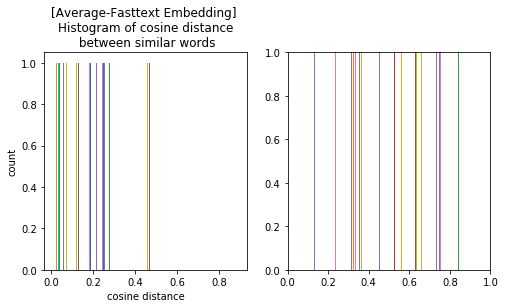

In [14]:
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 4))
data1 = pd.DataFrame(data=dis_with_same)
ax1.hist(data1, bins=np.arange(0,1,0.1))
ax1.set_title('[Average-Fasttext Embedding] \nHistogram of cosine distance\n between similar words')
ax1.set_xlabel('cosine distance')
ax1.set_ylabel('count')
data2 = pd.DataFrame(data=dis_with_other)
ax2.hist(data2, bins=np.arange(0,1,0.1))
ax2.set_title('[Average-Fasttext Embedding] \nHistogram of cosine distance\n between non-similar words')
ax2.set_xlabel('cosine distance')
ax2.set_ylabel('count')

Text(0, 0.5, 'count')

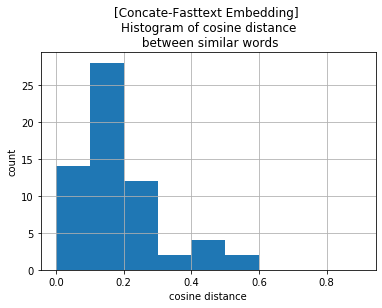

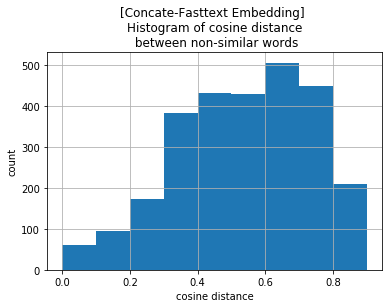

In [18]:
data1 = pd.DataFrame(data=dis_with_same)
ax1 = data1.hist(bins=np.arange(0,1,0.1))[0][0]
ax1.set_title('[Concate-Fasttext Embedding] \nHistogram of cosine distance\n between similar words')
ax1.set_xlabel('cosine distance')
ax1.set_ylabel('count')
data2 = pd.DataFrame(data=dis_with_other)
ax2 = data2.hist(bins=np.arange(0,1,0.1))[0][0]
ax2.set_title('[Concate-Fasttext Embedding] \nHistogram of cosine distance\n between non-similar words')
ax2.set_xlabel('cosine distance')
ax2.set_ylabel('count')